# Modulo principal, já temos a base de dados Amostra pronta, e farei a a mineiração dos dados dos campos necessários para executar o Modelo de Previsão de Seerie Temporais, o Prophet:
## 1) Campo Data da Aplicação da Vacina ('ds')
## 2) Campo Data Descricao Dose 1. Dose e 2. Dose ('y')

In [1]:
# DATA de Atualização; 01/06/2021

In [53]:
# Importando as principais Bibliotecas:

import csv
import time
import requests 
import pandas  as pd
import numpy   as np
import seaborn as sns
from random   import random
from datetime import datetime
from datetime import date


# Importar bibliotecas para construir gráficos:

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Bibliotecas de Algoritmos de Regressão:

from sklearn.tree            import DecisionTreeClassifier
from catboost                import CatBoostClassifier
from sklearn.metrics         import accuracy_score
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.ensemble        import RandomForestRegressor, ExtraTreesRegressor


# Biblioteca do Prophet para Algoritmo de Previsão:

from prophet             import Prophet
from prophet.plot        import plot_plotly
from prophet.plot        import plot_cross_validation_metric
from prophet.plot        import plot_components_plotly
from prophet.plot        import add_changepoints_to_plot
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation


# Leitura Banco Dados da Amostra no dia 26/05/2021:

df = pd.read_csv("BD_Amostra-Alguns-26-05-2021.csv", sep=";")
usecols   = ['vacina_fabricante_nome',
             'paciente_idade',
             'paciente_id',
             'vacina_dataAplicacao',
             'paciente_endereco_uf',
             'vacina_descricao_dose']

In [2]:
# Definindo Variaveis Globais:

FATOR_AMOSTRA = 0.001 # É o valor da porcentagem obtida pelo Banco de Dados Amostra: 1/1000

# A métrica MAPE (Mean absolute percentage error). \
Essa métrica nos mostra o quanto do ajuste está errado percentualmente.

In [4]:
# Função para calcular porcentagem Absoluta de Erro:

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Primeiro passo: 

1) Preparando o campo para o datetime: formato = %Y-%m-%dT%H:%M:%S"\
2) Denifir que o campo 'vacina_dataAplicacao' terá somente a DATA no formato: AAAA/MM/DD\
3) Remover o TimeZone do campo DATA


In [5]:
# Converter a coluna "vacina_dataAplicacao," datetime somente em date e tratando TimeZOne:


df['vacina_dataAplicacao'] = pd.to_datetime(df['vacina_dataAplicacao']).dt.date

df.dtypes

vacina_fabricante_nome    object
paciente_idade             int64
paciente_id               object
vacina_dataAplicacao      object
paciente_endereco_uf      object
vacina_descricao_dose     object
dtype: object

In [6]:
# Deixando a coluna "vacina_dataAplicacao" que será utilizada no Algoritmo de Previsão de Séries Temporais:

df['vacina_dataAplicacao']

0        2021-03-19
1        2021-03-03
2        2021-03-09
3        2021-04-01
4        2021-03-25
            ...    
61473    2021-05-25
61474    2021-05-07
61475    2021-05-25
61476    2021-05-25
61477    2021-05-25
Name: vacina_dataAplicacao, Length: 61478, dtype: object

# Segundo Passo: 
## Ordenar a coluna "vacina_dataAplicacao".

Uma das premissas para se trabalhar com série temporal:
devemos manter a ordem correta dos acontecimentos dos eventos.\
Portanto, vamos ordenar a coluna "vacina_dataAplicacao".

In [9]:
# Ordenando a coluna data:

df = df.sort_values('vacina_dataAplicacao')
df['vacina_dataAplicacao'].reset_index()

,index,vacina_dataAplicacao
0,25187,2020-03-23
1,26044,2020-03-23
2,51822,2020-03-23
3,20580,2021-01-18
4,1569,2021-01-18
...,...,...
61473,61427,2021-05-25
61474,61426,2021-05-25
61475,40803,2021-05-25
61476,59812,2021-05-25


# Terceiro Passo: Tratando do campo "vacina_descricao_dose":

   - Primeira Dose \
   - Segunda Dose após um intervalo definido\
   - Dose única

In [12]:

df["vacina_descricao_dose"].unique()

array(['1a_dose', '2a_dose', 'unica'], dtype=object)

# Note que o conteúdo do campo "data_descricao_dose":

array(['\xa0\xa0\xa0\xa01ª\xa0Dose', \
        '\xa0\xa0\xa0\xa02ª\xa0Dose']\
        '1ª Dose', '2ª Dose', 'Única'



In [13]:
# Tratando o campo "vacina_descricao_dose":

# 1) Transformando todos as linhas como Minuúsculas
# 2) Quando aparecer Null (NaN) substitui-se por "-"
# 3) Tratando todos os caracteres ASCII 

df["vacina_descricao_dose"] = (df["vacina_descricao_dose"]
                                 .str.lower()
                                 .str.normalize("NFKD")
                                 .str.lstrip()
                                 .str.replace(" ","_")
                                 .str.encode("ascii", errors="ignore")
                                 .str.decode("utf-8"))

# Quarto Passo: 

## Possibilidades do campo 'vacina_descricao_dose':

Teremos 3 situações para contabilizar o número de vacinas tomadas:
  1) A Primeira Dose ==> 1a_dose\
  2) A Segunda Dose  ==> Totalmente vacinados com a  2a_dose\
  3) Ser Dose Unica!!

In [9]:
# A dose unica aparece como valor = 1

# OBS: A vacina Jassen da Johnson&Johnson é somente 1 Dose
# df.loc[df["vacina_descricao_dose"] == 'unica', "vacina_descricao_dose" ] =  '1a_dose'

In [14]:
# Verificando o valor acumulado das doses tomadas:

df["vacina_descricao_dose"].value_counts()

1a_dose    42101
2a_dose    19376
unica          1
Name: vacina_descricao_dose, dtype: int64

# Quinto Passo: 
## Função: Get_Dummies no campo 'vacina_descricao_dose':

1) se não tomou vacina da 1ª Dose' = 0, se tomou a 1ª Dose' = 1 \
2) se não tomou vacina da 2ª Dose' = 0, se tomou a 2ª Dose' = 1



In [15]:
# Verificar o número de colunas Dataframe df ==> 6 colunas!!!
df.shape

(61478, 6)

In [16]:

dummies = df["vacina_descricao_dose"].str.get_dummies("\n")

In [17]:
dummies

,1a_dose,2a_dose,unica
25187,1,0,0
26044,1,0,0
51822,1,0,0
20580,1,0,0
1569,1,0,0
...,...,...,...
61427,0,1,0
61426,1,0,0
40803,1,0,0
59812,1,0,0


In [18]:
# Concatenar com o DataFrame e a coluna Dummies:

df = pd.concat([df, dummies], axis = 1)

In [19]:
# Após Concat com o Dummies, o Dataframe df acrescenta mais 3 colunas no df:

df.shape

(61478, 9)

# Fazendo o cálculo para valores com o FATOR_AMOSTRA

In [20]:
Vacinados_uma_dose = df['1a_dose'].sum()

print('Total REAL de Vacinados com 1. dose = ', Vacinados_uma_dose/FATOR_AMOSTRA)

Total REAL de Vacinados com 1. dose =  42101000.0


In [21]:
Vacinados_duas_doses = df['2a_dose'].sum()

print('Total REAL de Vacinados com 2. dose = ', Vacinados_duas_doses/FATOR_AMOSTRA)

Total REAL de Vacinados com 2. dose =  19376000.0


In [22]:
# Limpando os campos das Doses, retirando os nulos NaN

df['1a_dose'].fillna(0, inplace = True)

df['2a_dose'].fillna(0, inplace = True)

<AxesSubplot:xlabel='count', ylabel='vacina_descricao_dose'>

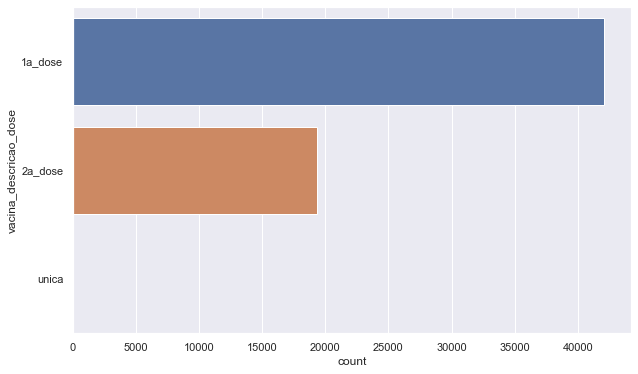

In [23]:
# Plotting das Doses tomadas:

plt.figure(figsize = (10,6))
sns.countplot(data = df, y = "vacina_descricao_dose")

# Sexto Passo: 

# Trabalhando com informações da '1a_dose' 
para executar o algoritmo de PREVISAO:
Neste ponto, vou definir o DataFrame df1 para '1a_dose'

In [26]:
# Agrupando as colunas da Data da Aplicacao com os vacinados da '1a_dose'

df1 = df.groupby('vacina_dataAplicacao').agg({'1a_dose':'sum'}).reset_index()

df1['vacina_dataAplicacao'].value_counts()

2021-04-20    1
2021-03-12    1
2021-05-14    1
2021-04-19    1
2021-05-02    1
             ..
2021-01-24    1
2021-04-09    1
2021-03-13    1
2021-01-20    1
2021-03-17    1
Name: vacina_dataAplicacao, Length: 129, dtype: int64

# Sétimo Passo: 

# O Algoritmo do Prophet para Previsao Séries Temporais: 

dois campos importantes 'ds' e 'y', onde:\
ds       => é a coluna DATA e já está no formato de AAAA-MM-DD\
coluna y => deve ser numérica e representa a medida que desejamos prever:

## Aqui vou separar em duas etapas as previsões: 
 y = 1.dose total da para dataframe ==> df1 \
 y = 2.dose para dataframe          ==> df2

In [27]:
# A primeira etapa será previsão da 1.dose:

df1.tail(5)

,vacina_dataAplicacao,1a_dose
124,2021-05-21,342
125,2021-05-22,231
126,2021-05-23,26
127,2021-05-24,294
128,2021-05-25,235


In [27]:
# Plotting the TIme Series Data

In [29]:
# Renomeando as colunas para preparar para rodar o Modelo Prophet:

df1.columns = ['ds', 'y']

<AxesSubplot:title={'center':'Tempo Data Series'}, xlabel='ds'>

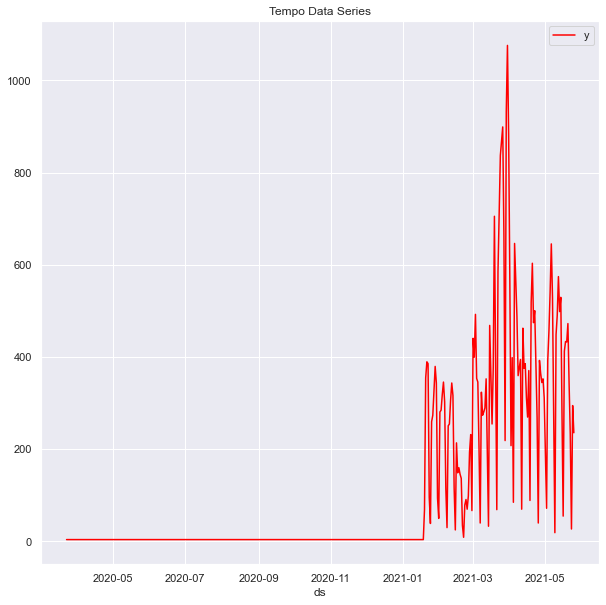

In [30]:
df1.plot(x ='ds', y ='y', figsize = (10,10), title = 'Tempo Data Series' , color = 'red')

# Oitavo Passo: 
## Definifindo a sazonalidade dos períodos: diario, mensal, anual ou quinzenal:

In [31]:
# Definindo a sazonalidade diaria, semanal e mensal terá mais controle sobre a sazonalidade. 

model = Prophet(daily_seasonality      = False,
               weekly_seasonality      = False,
               yearly_seasonality      = False,
               ).add_seasonality(name= 'mounthly',
                                 period = 30,
                                 fourier_order = 12
                ).add_seasonality(name = 'dayly',
                                 period = 1,
                                 fourier_order = 15
                                 ).add_seasonality(name = 'weekly',
                                 period = 7,
                                 fourier_order = 20,
                ).add_seasonality(name= 'yearly',
                                 period = 365.25,
                                 fourier_order = 20
                ).add_seasonality(name= 'quartely',
                                 period = 365.25/4,
                                 fourier_order = 5,
                                 prior_scale = 15)
                

# Décimo Passo: Executando o Modelo de Prophet()

## Definindo parâmetros do Prophet(), assegurando que teremos a previsão positiva:


In [32]:
# Fazendo Saturações Previsões de Crescimento:

# Iremos obter um dataframe adequado que se estende até o futuro
# por um determinado número de dias usando o método auxiliar Prophet.make_future_dataframe. 

model = Prophet()

# Faremos o treinamento:
model.fit(df1)


# O Prophet disponibiliza um dataframe adequado que se estenda para o futuro 
# por um número especificado de dias (que escolhemos para prever) 
# usando o método auxiliar `make_future_dataframe.

future   = model.make_future_dataframe(periods = 365) # previsão de 1 ano 


# O método PREDICT, atribuirá cada linha em future um valor previsto que ele nomeia yhat. 
# Se você passar datas históricas, isso fornecerá um ajuste na amostra. 
# O bjeto FORECAST é um novo dataframe que inclui uma coluna yhatcom a previsão, 
# bem como colunas para componentes e intervalos de incerteza.

forecast = model.predict(future)

# A coluna yhat representa as previsões, 
# o yhat_lower e yhat_upper são as componentes do intervalo de incertezas
# Quanto mais distante o tempo à frente, mais incerto fica a previsão.


forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
489,2022-05-21,840.911142,616.863303,1059.873922
490,2022-05-22,643.027603,427.999018,849.290717
491,2022-05-23,993.534785,773.807592,1210.250621
492,2022-05-24,990.130664,782.142774,1227.911994
493,2022-05-25,1020.635811,796.745004,1230.738037


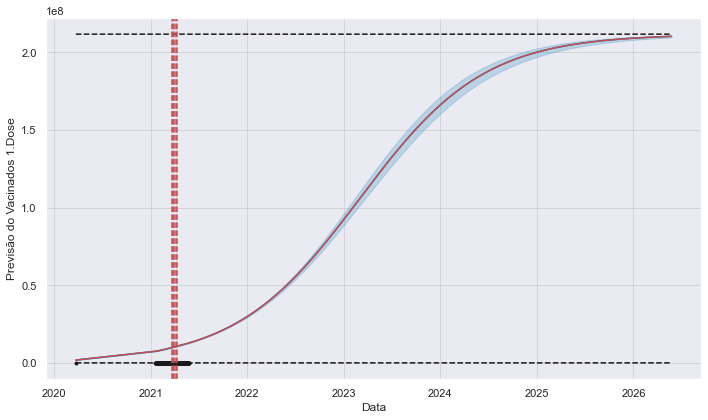

In [43]:
# Plotting, as previsões do modelo treinado:

fig1 = model.plot(forecast, xlabel = 'Data', ylabel = 'Previsão do Vacinados 1.Dose')
a = add_changepoints_to_plot(fig1.gca(), model, forecast)

<AxesSubplot:title={'center':'Data Atual x Previsão'}, xlabel='ds'>

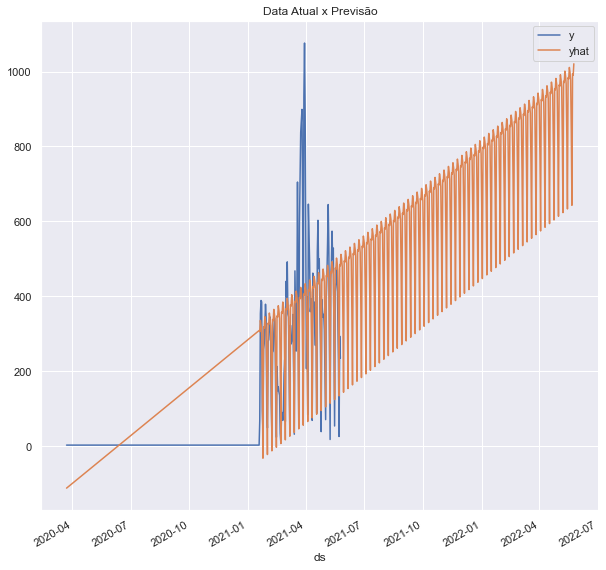

In [33]:
# Plotting o atual e os valores obtidos do Forecast:

ax = (df1.plot(x = 'ds', y = 'y',  figsize =(10,10), title = "Data Atual x Previsão"))
forecast.plot( x = 'ds', y ='yhat',figsize =(10,10), title = "Data Atual x Previsão", ax =ax )

# Chamando a Função: Mean_Absolute_Percentage_ERROR

## Definindo os campos de y_true e y_pred para calcular erro,


In [34]:
# Definindo os campos de y_true e y_pred para calcular erro,
# chamando a Função Mean_Absolute_Percentage_ERROR

y_true = df1['y']
y_pred = forecast['yhat'].loc[0:128]

mape = mean_absolute_percentage_error(y_true, y_pred)

print("MAPE", round(mape,4))


MAPE 168.1857


# Calculando as métricas:

In [56]:
# Utilizando a Função Croos-Validation

df_cross = cross_validation(model, initial='100 days', period='180 days', horizon = '100 days')

INFO:prophet:Making 1 forecasts with cutoffs between 2021-02-14 00:00:00 and 2021-02-14 00:00:00


INFO:prophet:n_changepoints greater than number of observations. Using 22.


In [57]:
df_cross.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-02-15,210.589252,144.770834,277.486956,213,2021-02-14
1,2021-02-16,231.059478,159.886804,299.972509,148,2021-02-14
2,2021-02-17,337.305298,272.141006,406.305637,159,2021-02-14
3,2021-02-18,375.304151,302.826658,448.674072,145,2021-02-14
4,2021-02-19,347.805919,274.979404,419.726579,136,2021-02-14


In [58]:
df_perform = performance_metrics(df_cross)
df_perform.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,10 days,25919.367737,160.994931,138.155296,1.936561,1.602958,0.859019,0.2
1,11 days,33861.580048,184.015163,166.097183,2.223011,1.687746,0.975843,0.1
2,12 days,35710.341478,188.971801,173.724374,2.249445,1.687746,0.990453,0.1
3,13 days,33755.579809,183.726916,166.959631,2.185207,1.687746,0.981592,0.1
4,14 days,28474.544782,168.744021,145.444642,2.049337,1.687746,0.919004,0.2


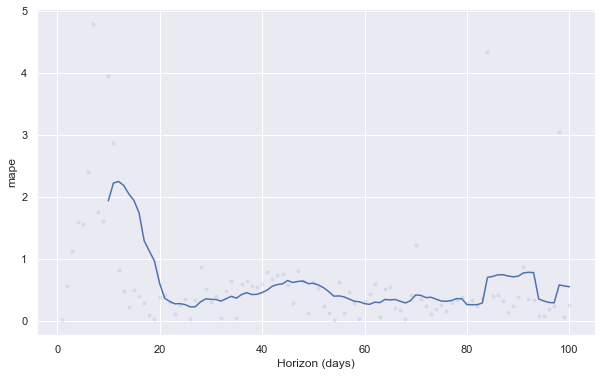

In [59]:
# Plotting a Performance:

fig = plot_cross_validation_metric(df_cross, metric='mape')

# Ajustando Parâmetros: ajustes para melhorar a nossa previsão:

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


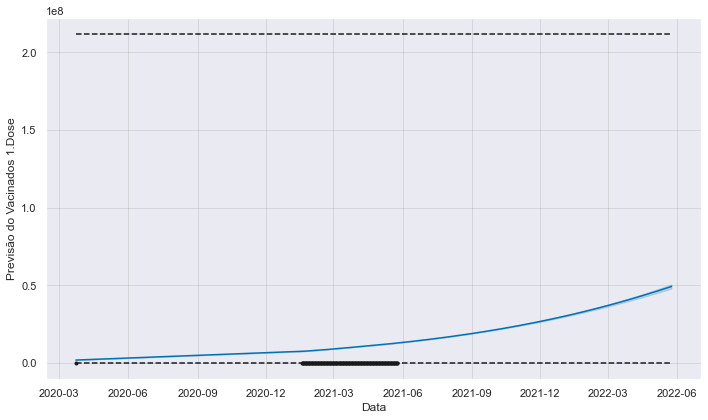

In [60]:
# Prophet usa um modelo linear para sua previsão, e podemos usar um modelo de
# 1) A tendência de crescimento logística, 'growth = logistic'

# 2) Dois parâmetros são importantes no modelo:
# o parâmetro FLOOR = 1     ==> mínimo de saturação 
# o parâmetro CAP   = 7000  ==> especifica o valor máximo, CAP = populacao brasileira

# 3) Parâmetro Trend, podemos ajustar a flexibilizar a tendência:

# Se as mudanças de tendência estão sendo super ajustadas (flexibilidade demais) ou insuficientes (flexibilidade insuficiente), você pode ajustar a força da dispersão antes de usar o argumento de entrada changepoint_prior_scale. 
# Por padrão, este parâmetro é definido como 0,05. 
# Aumentá-lo tornará a tendência mais flexível


# OBS: FLOOR e CAP devem ser especificados para CADA colunas do DataFrame, com
# valores mínimo e Máximo

df1['cap']  = 7000   # media vacinados por dia
df1['floor'] = 1      # valor do piso

model = Prophet(growth = 'logistic', changepoint_prior_scale = 0.5)  # define crescimento logistico
 
# Calculando fit:
model.fit(df1)

# Fazendo a previsão:

future        = model.make_future_dataframe(periods = 365)
future['cap']   = 211755692   # total da população brasileira
future['floor'] = 1
forecast = model.predict(future)

fig3 = model.plot(forecast, xlabel = 'Data', ylabel = 'Previsão do Vacinados 1.Dose')

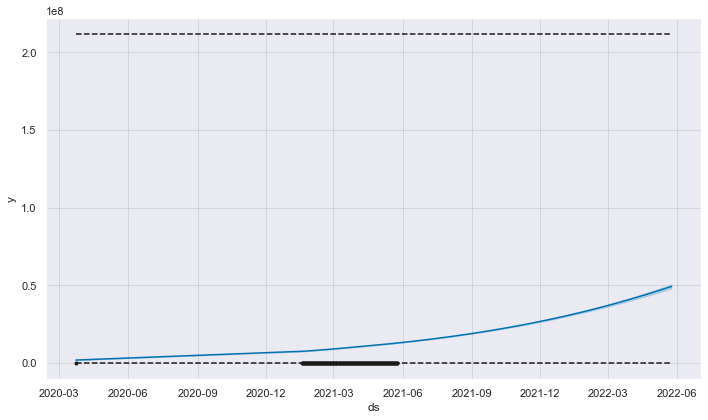

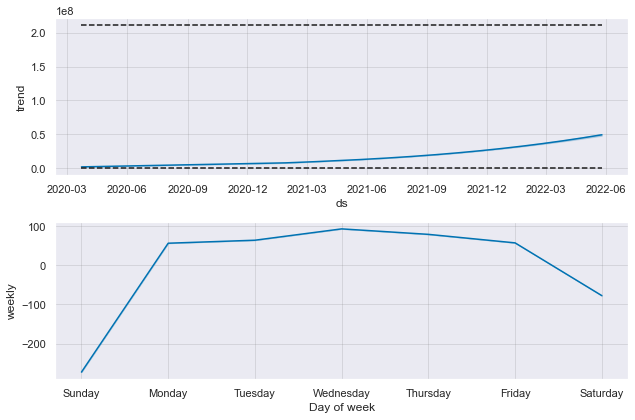

In [38]:
# Fazendo o Plotagem da Previsão:

fig4 = model.plot(forecast, uncertainty = True)

fig5 = model.plot_components(forecast)

In [67]:
# Explicando as métricas:

# yhat: o valor previsto de nossa métrica (em Estatísticas, 
#       yhat é uma notação tradicionalmente usada para representar os valores previstos de um valor y)

# yhat_lower: o limite inferior de nossas previsões
# yhat_upper: o limite superior de nossas previsões


forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
489,2022-05-21,4.858716e+07,4.728644e+07,4.988055e+07
490,2022-05-22,4.874605e+07,4.743605e+07,5.004837e+07
491,2022-05-23,4.890583e+07,4.758635e+07,5.021956e+07
492,2022-05-24,4.906565e+07,4.773763e+07,5.039096e+07
493,2022-05-25,4.922586e+07,4.788769e+07,5.056197e+07


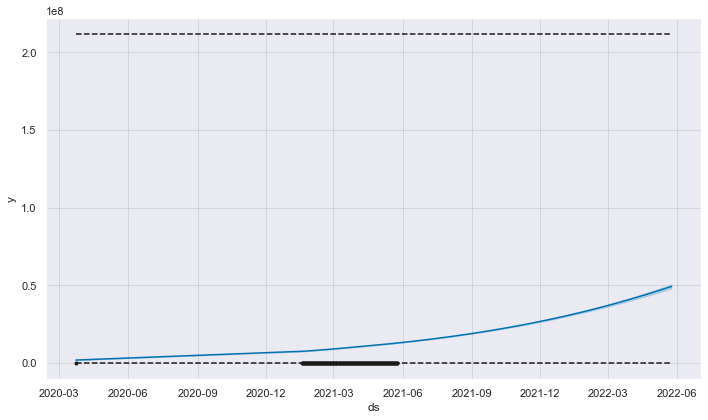

In [43]:
fig = model.plot(forecast)

<AxesSubplot:title={'center':'DADOS ATUAIS X FUTURO'}, xlabel='ds'>

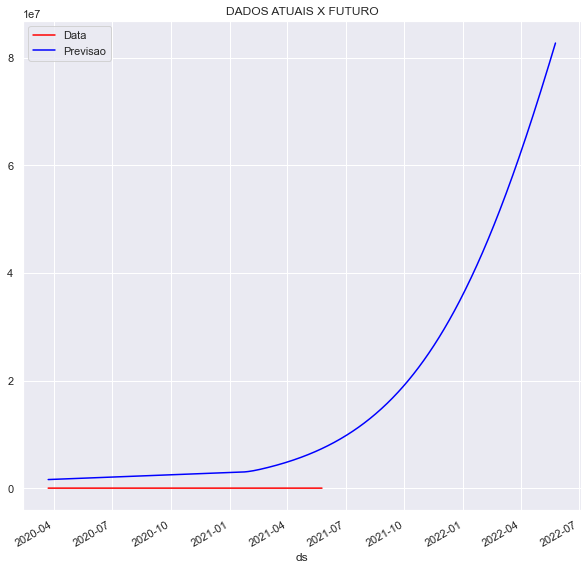

In [67]:
# Plotting comparando valores: Atual x Futuro: 

ax = (df1.plot(x= 'ds', y = 'y',   legend = True, label = 'Data', figsize= (10,30), color = 'red')) 
forecast.plot(x= 'ds',  y ='yhat', legend = True, label = 'Previsao', figsize=(10,10),title='DADOS ATUAIS X FUTURO', color ='blue',ax=ax)

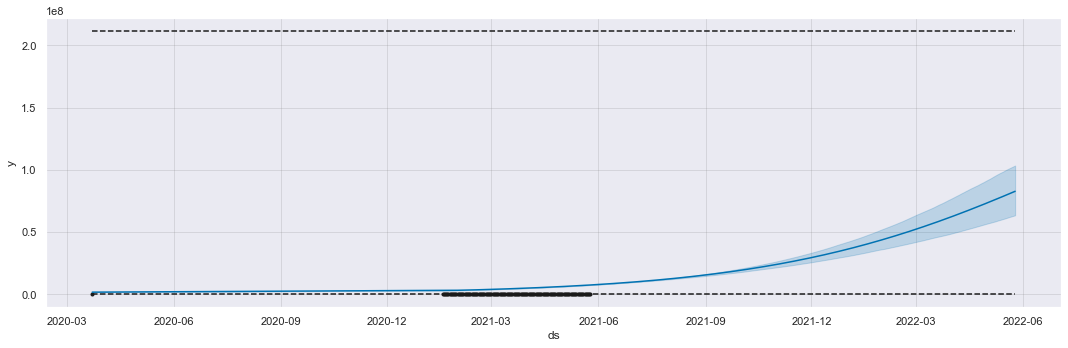

In [62]:
# Plotting o forecast:
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast, ax=ax)
plt.show()

In [ ]:
# Explicando o gráfico abaixo:

# Usando a add_changepoints_to_plotfunção, adicionamos as linhas vermelhas; 
# as linhas tracejadas verticais são pontos de mudança que o Prophet identificou onde a tendência mudou, 
# e a linha vermelha contínua, é a tendência com toda a sazonalidade removida.

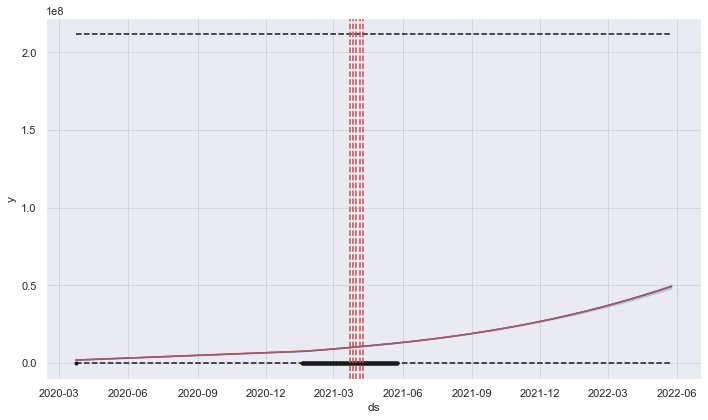

In [44]:
# Plotting dados Atual x Futuro

fig = model.plot(forecast)
a   = add_changepoints_to_plot(fig.gca(), model, forecast)

In [61]:
# Recalculando a Função Croos-Validation

df_cross = cross_validation(model, initial='100 days', period='180 days', horizon = '100 days')

df_cross.head()
df_perform = performance_metrics(df_cross)
df_perform.head()

INFO:prophet:Making 1 forecasts with cutoffs between 2021-02-14 00:00:00 and 2021-02-14 00:00:00


INFO:prophet:n_changepoints greater than number of observations. Using 22.


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,10 days,30961.735237,175.959470,154.073701,2.296622,1.772392,0.916400,0.2
1,11 days,40164.911775,200.411855,183.428016,2.601658,1.927526,1.033344,0.1
2,12 days,42496.968505,206.147929,191.789459,2.629599,1.927526,1.047641,0.1
3,13 days,39553.420103,198.880417,181.334995,2.546497,1.927526,1.019484,0.1
4,14 days,33545.859512,183.155288,157.536467,2.388333,1.927526,0.938231,0.2


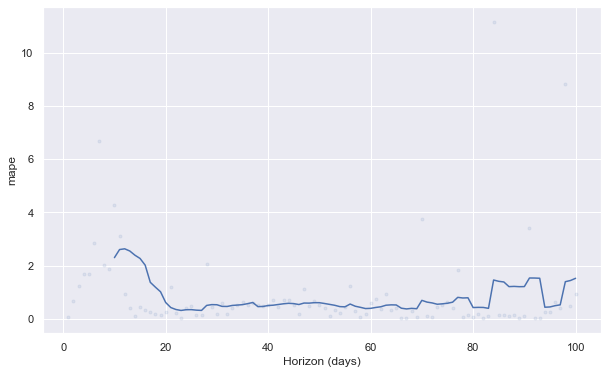

In [62]:
# Plotting a Performance:

fig = plot_cross_validation_metric(df_cross, metric='mape')

In [ ]:
Next we will see if adding holiday indicators will help the accuracy of the model. 
Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

In [77]:
# Adicionando os Feriados do Brasil para melhorar a acurária da Previsão da Serie Temporal:

import holidays
    
feriado = holidays.Brazil()
    
for feriado in feriado['2021-01-01': '2021-12-31'] :
    print(feriado)

2021-01-01
2021-02-16
2021-02-17
2021-04-02
2021-04-04
2021-04-21
2021-05-01
2021-06-03
2021-09-07
2021-10-12
2021-11-02
2021-11-15
2021-12-25


In [74]:
# Criando um Dataframe que contém as datas dos feriados:

feriado_df = df1

feriado_df['data_feriado'] = df1.date.isin([d.date() for d in feriado])
holiday_df = df1.loc[df1['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
feriado_df['data_feriado'] = 'USFederalHoliday'
feriado_df = holiday_df.drop(['ds','date','is_holiday'], axis=1)
feriado_df.head()
feriado_df['data_feriado'] = feriado
feriado_df

,ds,y,cap,floor,data_feriado
0,2020-03-23,3,7000,1,2021-12-25
1,2021-01-18,3,7000,1,2021-12-25
2,2021-01-19,68,7000,1,2021-12-25
3,2021-01-20,354,7000,1,2021-12-25
4,2021-01-21,389,7000,1,2021-12-25
...,...,...,...,...,...
124,2021-05-21,342,7000,1,2021-12-25
125,2021-05-22,231,7000,1,2021-12-25
126,2021-05-23,26,7000,1,2021-12-25
127,2021-05-24,294,7000,1,2021-12-25


# Após os ajustes nos parâmetros da Prophet,
refazendo a função de Erro Absoluto: 


In [41]:
# Definindo os campos de y_true e y_pred para calcular erro,
# chamando a Função Mean_Absolute_Percentage_ERROR
# Após alterando parâmetros no Prophet:

y_true = df1['y']
y_pred = forecast['yhat'].loc[0:128]

mape = mean_absolute_percentage_error(y_true, y_pred)

print("MAPE", round(mape,4))


MAPE 9466520.793


# Aqui estarei fazendo as Previsões da Segunda Dose da Vacina:

In [47]:
df2 = df
df2.shape

(61478, 9)

In [45]:
df2 = df.groupby('vacina_dataAplicacao').agg({'2a_dose':'sum'}).reset_index()

df2['vacina_dataAplicacao'].value_counts()

2021-01-18    1
2021-01-22    1
2021-02-16    1
2021-02-03    1
2021-05-15    1
             ..
2021-01-23    1
2021-01-30    1
2021-03-03    1
2021-03-20    1
2021-03-06    1
Name: vacina_dataAplicacao, Length: 129, dtype: int64

In [46]:
# Renomeando as colunas para preparar para rodar o Modelo Prophet:

df2.columns = ['ds', 'y']

In [47]:
df2

,ds,y
0,2020-03-23,0
1,2021-01-18,0
2,2021-01-19,1
3,2021-01-20,0
4,2021-01-21,0
...,...,...
124,2021-05-21,161
125,2021-05-22,95
126,2021-05-23,16
127,2021-05-24,164


<AxesSubplot:title={'center':'Datas Vacinação da 2. Dose'}, xlabel='ds'>

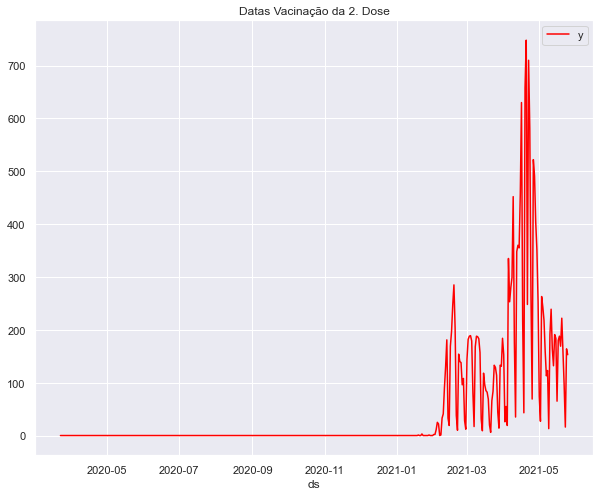

In [57]:
# Plotting Data Atual

df2.plot(x ='ds', y ='y', figsize = (10,8), title = 'Datas Vacinação da 2. Dose' , color = 'red')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


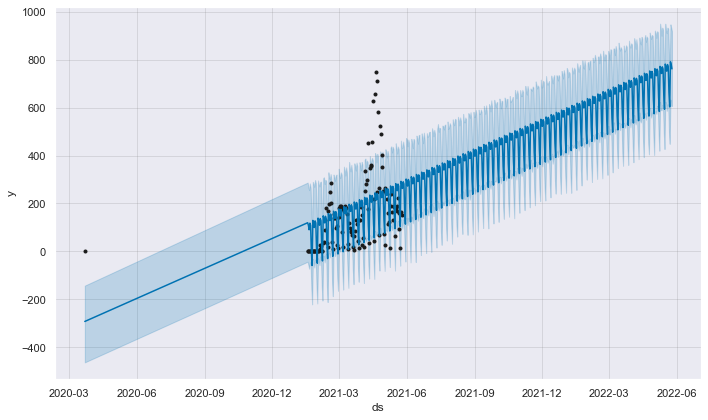

In [48]:
# Fazendo Saturações Previsões de Crescimento com Prophet sem nenhum parâmetros:

model = Prophet()

model.fit(df2)

future   = model.make_future_dataframe(periods = 365)

forecast = model.predict(future)

fig1 = model.plot(forecast)


In [49]:
# Definindo os campos de y_true e y_pred para calcular erro,
# chamando a Função Mean_Absolute_Percentage_ERROR
# Após alterando parâmetros no Prophet:

y_true = df2['y']
y_pred = forecast['yhat'].loc[0:128]

mape = mean_absolute_percentage_error(y_true, y_pred)

print("MAPE", round(mape,4))


MAPE inf


<ipython-input-3-21ce4e0c75b3>:5: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [50]:
# Definindo a sazonalidade diaria, semanal e mensal terá mais controle sobre a sazonalidade. 

model = Prophet(daily_seasonality      = False,
               weekly_seasonality      = False,
               yearly_seasonality      = False,
               ).add_seasonality(name= 'mounthly',
                                 period = 30,
                                 fourier_order = 12
                ).add_seasonality(name = 'dayly',
                                 period = 1,
                                 fourier_order = 15
                                 ).add_seasonality(name = 'weekly',
                                 period = 7,
                                 fourier_order = 20,
                ).add_seasonality(name= 'yearly',
                                 period = 365.25,
                                 fourier_order = 20
                ).add_seasonality(name= 'quartely',
                                 period = 365.25/4,
                                 fourier_order = 5,
                                 prior_scale = 15)
                

# Tratando Parâmetros: ajustes dos parâmetros do PROPHETS para '2a_dose':

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


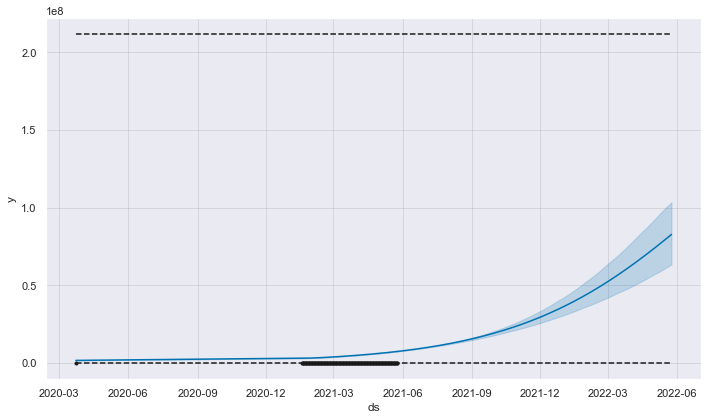

In [51]:
# Aqui faremos os ajustes para melhorar a nossa previsão:

# Prophet usa um modelo linear para sua previsão, e podemos usar um modelo de
# 1) A tendência de crescimento logística, 'growth = logistic'

# 2) Dois parâmetros são importantes no modelo:
# o parâmetro FLOOR = 0 ==> mínimo de saturação 
# o parâmetro CAP   =   ==> especifica o valor máximo, CAP = populacao brasileira

# 3) Parâmetro Trend, podemos ajustar a flexibilizar a tendência:

# Se as mudanças de tendência estão sendo super ajustadas (flexibilidade demais) ou insuficientes (flexibilidade insuficiente), você pode ajustar a força da dispersão antes de usar o argumento de entrada changepoint_prior_scale. 
# Por padrão, este parâmetro é definido como 0,05. 
# Aumentá-lo tornará a tendência mais flexível


# OBS: FLOOR e CAP devem ser especificados para CADA colunas do DataFrame, com
# valores mínimo e Máximo

df2['cap']  = 7000    # media vacinados por dia
df2['floor'] = 1      # valor do piso

model = Prophet(growth = 'logistic', changepoint_prior_scale = 0.5)  # define crescimento logistico
 
# Calculando fit:
model.fit(df2)

# Fazendo a previsão:

future          = model.make_future_dataframe(periods = 365)
future['cap']   = 211755692   # total da população brasileira
future['floor'] = 1
forecast = model.predict(future)

fig3 = model.plot(forecast)

In [52]:
# Explicando as métricas:

# yhat: o valor previsto de nossa métrica (em Estatísticas, 
#       yhat é uma notação tradicionalmente usada para representar os valores previstos de um valor y)

# yhat_lower: o limite inferior de nossas previsões
# yhat_upper: o limite superior de nossas previsões


forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
489,2022-05-21,8.114205e+07,6.229156e+07,1.016694e+08
490,2022-05-22,8.153731e+07,6.257422e+07,1.021166e+08
491,2022-05-23,8.193352e+07,6.285823e+07,1.025640e+08
492,2022-05-24,8.233028e+07,6.314228e+07,1.030094e+08
493,2022-05-25,8.272770e+07,6.342755e+07,1.034545e+08


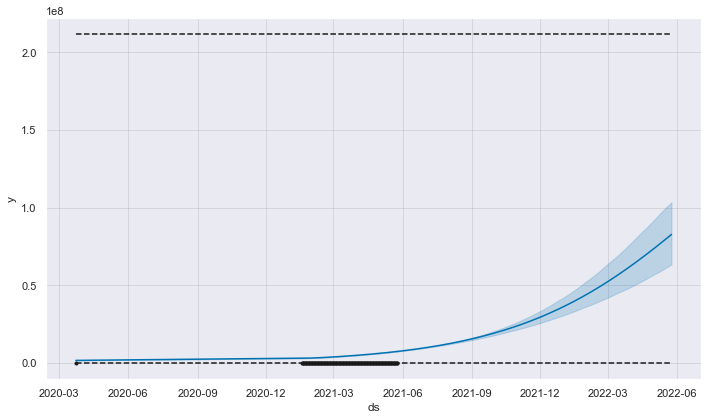

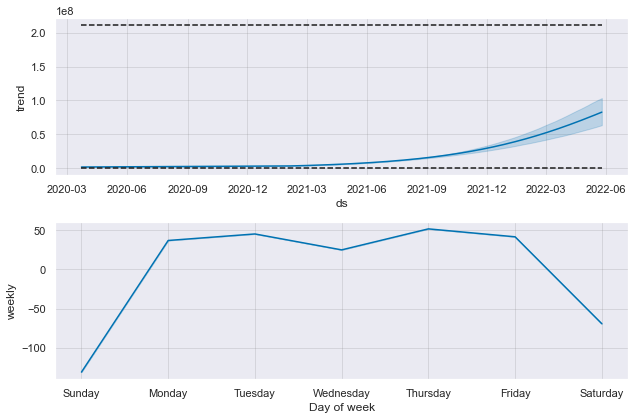

In [53]:
# Fazendo o Plotagem:

fig = model.plot(forecast)

fig = model.plot_components(forecast)

In [54]:
# Definindo os campos de y_true e y_pred para calcular erro,
# chamando a Função Mean_Absolute_Percentage_ERROR
# Após alteração parâmetros no Prophet:

y_true = df2['y']
y_pred = forecast['yhat'].loc[0:128]

mape = mean_absolute_percentage_error(y_true, y_pred)

print("MAPE", round(mape,4))


MAPE inf


<ipython-input-3-21ce4e0c75b3>:5: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
